In [60]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import gsw

#=================================================
# Modify paths to point to output files
#=================================================
# Case name
case = 'Straight Coast'

# path to ocean_annual file
path_year_rho2 = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/500yr/23000101.ocean_annual_rho2.nc'
dy_rho2 = xr.open_dataset(path_year_rho2, decode_times=True)

# path to ocean_annual file
path_year_z = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/500yr/23000101.ocean_annual_z.nc'
dy_z = xr.open_dataset(path_year_z, decode_times=True)

# path to ocean_annual file
path_year = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/500yr/23000101.ocean_annual.nc'
dy = xr.open_dataset(path_year, decode_times=True)

# path to save figures
fig_path = '/data/sragen/aquaplanet/MASTERS/straight_coast/run/DATA/500yr/FIGURES/'

#=================================================
# Ignore runtime warnings: mean of empty slice
#=================================================
warnings.filterwarnings("ignore", message="Mean of empty slice")

#=================================================
# Modify latitudes to point to western and eastern
# boundaries of small basin and northern extent of SO.
# Comment out for AQUA and RIDGE cases. 
#=================================================
x_west = np.where(dy['xh']==211)[0][0]
x_east = np.where(dy['xh']==351)[0][0]
y = np.where(dy['yq']==-35)[0][0]
y_south = np.where(dy['yq']==-71)[0][0]
y_north = np.where(dy['yq']==71)[0][0]

/home/sragen/.conda/envs/aqua/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


In [47]:
dy['d']

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 180, xq: 180, yh: 81, yq: 81, zl: 31)
Coordinates:
  * xh          (xh) float64 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * yh          (yh) float64 -80.0 -78.0 -76.0 -74.0 ... 74.0 76.0 78.0 80.0
  * time        (time) object 2300-07-02 12:00:00 ... 2399-07-02 12:00:00
  * nv          (nv) float64 1.0 2.0
  * zl          (zl) float64 2.5 10.0 20.0 32.5 ... 3.5e+03 4e+03 4.625e+03
  * xq          (xq) float64 2.0 4.0 6.0 8.0 10.0 ... 354.0 356.0 358.0 360.0
  * yq          (yq) float64 -79.0 -77.0 -75.0 -73.0 ... 75.0 77.0 79.0 81.0
Data variables:
    pbo         (time, yh, xh) float32 ...
    pso         (time, yh, xh) float32 ...
    masscello   (time, zl, yh, xh) float32 ...
    thkcello    (time, zl, yh, xh) float32 ...
    zos         (time, yh, xh) float32 ...
    zossq       (time, yh, xh) float32 ...
    thetao      (time, zl, yh, xh) float32 ...
    tos         (time, yh, xh) float32 ...
    tossq       (time, yh, xh) float32 ...
    tob         (time, yh, xh) float32 ...
    so          (time, zl, yh, xh) float32 ...
    sos         (time, yh, xh) float32 ...
    sossq       (time, yh, xh) float32 ...
    sob         (time, yh, xh) float32 ...
    mlotst      (time, yh, xh) float32 ...
    mlotstsq    (time, yh, xh) float32 ...
    mlotstmin   (time, yh, xh) float32 ...
    mlotstmax   (time, yh, xh) float32 ...
    uo          (time, zl, yh, xq) float32 ...
    vo          (time, zl, yq, xh) float32 ...
    uhml        (time, zl, yh, xq) float32 ...
    vhml        (time, zl, yq, xh) float32 ...
    average_T1  (time) object ...
    average_T2  (time) object ...
    average_DT  (time) timedelta64[ns] ...
    time_bnds   (time, nv) timedelta64[ns] ...
Attributes:
    filename:          23000101.ocean_annual.nc
    title:             Aquaplanet
    associated_files:  areacello: 23000101.ocean_static.nc
    grid_type:         regular
    grid_tile:         N/A

In [96]:
def calc_sigma2(dy_case, salt, temp):
    CT = xr.apply_ufunc(gsw.CT_from_pt, salt, temp, dask='parallelized', output_dtypes=[float,])

    sigma2 = xr.apply_ufunc(gsw.sigma2, salt, CT, dask='parallelized', output_dtypes=[float,])
    
    sigma2_xarray = temp.copy()
    sigma2_xarray.attrs['units'] = 'kg/m^3' 
    sigma2_xarray.attrs['long_name'] = 'potential density referenced to 2000 dbar'
    sigma2_xarray.attrs['standard_name'] = 'sigma2'
    sigma2_xarray.values = sigma2
    
    return sigma2_xarray


def calculate_global_sfn(vmo, vhGM):
    vmo_slice = vmo.isel(time=slice(-31,-1)).mean(dim='time')
    vhGM_slice = vhGM.isel(time=slice(-31,-1)).mean(dim='time')
    sfn_global_resmean = (np.cumsum(np.nansum(vmo_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_res = (np.cumsum(np.nansum(vhGM_slice/1025, axis=2), axis=0))/(1e6)
    sfn_global_mean = sfn_global_resmean - sfn_global_res
    return sfn_global_mean, sfn_global_res, sfn_global_resmean


def calculate_basin_sfn(vmo, vhGM, x_west, x_east, y_south, y_north):
    vmo_slice = vmo.isel(time=slice(-31,-1)).mean(dim='time')
    vhGM_slice = vhGM.isel(time=slice(-31,-1)).mean(dim='time')
    sfn_basin_resmean = (np.cumsum(np.nansum((vmo_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_res = (np.cumsum(np.nansum((vhGM_slice[:,y_south:y_north,x_west:x_east])/1025, axis=2), axis=0))/(1e6)
    sfn_basin_mean = sfn_basin_resmean - sfn_basin_res
    return sfn_basin_mean, sfn_basin_res, sfn_basin_resmean


def variablename(*arg):
    names = []
    for i in range(len(arg)):
        item = [tpl[0] for tpl in filter(lambda x: arg[i] is x[1], globals().items())]
        names.append(item)
    str(names).strip('[]')
    return names

def plot_global_sfn(sfn_mean, sfn_res, sfn_resmean, sfn_bound, dataset):
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_mean, sfn_res, sfn_resmean
    names = variablename(sfn_mean, sfn_res, sfn_resmean)
    sname = str(names[2]).strip("['']")
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(dataset.yq, dataset.rho2_l-1000, sfn_list[row], b, cmap='RdBu_r', extend='both')
        ax.set_ylim(25, 37.7)
        ax.invert_yaxis()
        ax.set_xlim(-70, 70)
        plt.ylabel('Density', fontsize=14), plt.xlabel('Latitude', fontsize=14)
        ax.set_title('{}'.format(str(names[row]).strip("['']"))+' '+'{}'.format(case), fontsize=16)
        cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
    axs[2].set_ylabel('$\sigma_2$ [kg m$^{-3}$]', fontsize=14), axs[2].set_xlabel('Latitude', fontsize=14)
    plt.savefig(fig_path+'{}_global.png'.format(sname))
    plt.show()
    return


def plot_basin_sfn(sfn_mean, sfn_res, sfn_resmean, sfn_bound, dataset, y_south, y_north):
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8,12))
    sfn_list = sfn_mean, sfn_res, sfn_resmean
    names = variablename(sfn_mean, sfn_res, sfn_resmean)
    sname = str(names[2]).strip("['']")
    for row in range(3):
        ax = axs[row]
        cf = ax.contourf(dataset.yq[y_south:y_north], dataset.rho2_l-1000, sfn_list[row][:,:], 
                         b, cmap='RdBu_r', extend='both')
        ax.set_ylim(25, 37.7)
        ax.invert_yaxis()
        ax.set_xlim(dataset.yq[y_south], dataset.yq[y_north-1])
        ax.set_title('{}'.format(str(names[row]).strip("['']"))+' '+'{}'.format(case), fontsize=16)
        cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
        cbar.ax.set_ylabel('[Sv]', fontsize=12)
    axs[2].set_ylabel('$\sigma_2$ [kg m$^{-3}$]', fontsize=14), axs[2].set_xlabel('Latitude', fontsize=14)
    plt.savefig(fig_path+'{}.png'.format(sname))
    plt.show()
    return


def plot_global_sfn_density(sfn_resmean, sfn_bound, dataset):
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, ax = plt.subplots(figsize=(8,4))
    cf = ax.contourf(dataset.yq, dataset.z_l, sfn_resmean, b, cmap='RdBu_r', extend='both')
    c = ax.contour(dataset.sigma2.yh, dataset.sigma2.zl, dataset.sigma2.mean(dim='xh'), levels=8, colors='black')
    ax.clabel(c, inline=True, inline_spacing=2, fmt='%.0f', fontsize=10, rightside_up=True)
    ax.invert_yaxis()
    ax.set_xlim(-70, 70)
    plt.ylabel('Depth [m]', fontsize=14), plt.xlabel('Latitude', fontsize=14)
    ax.set_title('{}'.format(case)+' Residual Mean Overturning', fontsize=16)
    cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
    cbar.ax.set_ylabel('[Sv]', fontsize=12)
    plt.savefig(fig_path+'sfn_density_global.png')
    plt.show()
    return


def plot_basin_sfn_density(sfn_resmean, sfn_bound, dataset, basin, x_west, x_east, y_south, y_north):
    t = np.linspace(-sfn_bound, sfn_bound, 11, endpoint=True)
    b = np.linspace(-sfn_bound, sfn_bound, 21, endpoint=True)
    fig, ax = plt.subplots(figsize=(8,4))
    cf = ax.contourf(dataset.yq.isel(yq=slice(y_south,y_north)), dataset.z_l, sfn_resmean, 
                     b, cmap='RdBu_r', extend='both')
    c = ax.contour(dataset.sigma2.yh.isel(yh=slice(y_south-1,y_north+1)), dataset.sigma2.zl, 
                   dataset.sigma2.isel(xh=slice(x_west, x_east)).isel(yh=slice(y_south-1,y_north+1)).mean(dim='xh'), 
                   levels=8, colors='black')
    ax.clabel(c, inline=True, inline_spacing=2, fmt='%.0f', fontsize=10, rightside_up=True)
    ax.invert_yaxis()
    ax.set_xlim(dataset.yq[y_south], dataset.yq[y_north-1])
    cbar = fig.colorbar(cf, ax=ax, ticks=t, format = '%.0f')
    cbar.ax.set_ylabel('[Sv]', fontsize=12)
    ax.set_title('{}'.format(case)+' '+'{}'.format(basin)+' Residual Mean Overturning', fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=14), ax.set_xlabel('Latitude', fontsize=14)
#     plt.savefig(fig_path+'{}.png'.format(sname))
    plt.show()
    return



In [34]:
# Calculate global mean, residual, and residual mean overturning streamfunction
sfn_mean, sfn_res, sfn_resmean = calculate_global_sfn(dy_rho2.vmo, dy_rho2.vhGM)

#===========================================
# Comment out the lines below if running AQUA or RIDGE simulations (or simulations with only 1 basin)
# The following lines compute streamfunctions for separate basins.
sfn_small_mean, sfn_small_res, sfn_small_resmean = calculate_basin_sfn(dy_rho2.vmo, dy_rho2.vhGM, 
                                                                       x_west, x_east, y, y_north)
sfn_large_mean, sfn_large_res, sfn_large_resmean = calculate_basin_sfn(dy_rho2.vmo, dy_rho2.vhGM, 
                                                                       0, x_west, y, y_north)
sfn_so_mean, sfn_so_res, sfn_so_resmean = calculate_basin_sfn(dy_rho2.vmo, dy_rho2.vhGM, 0, 360, y_south, y)


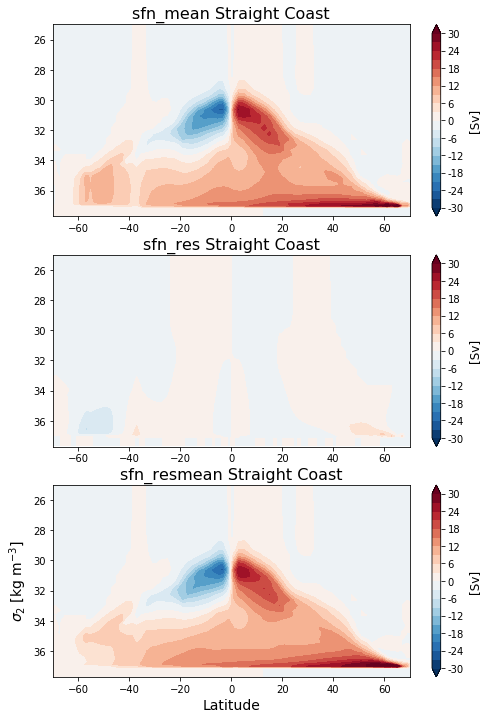

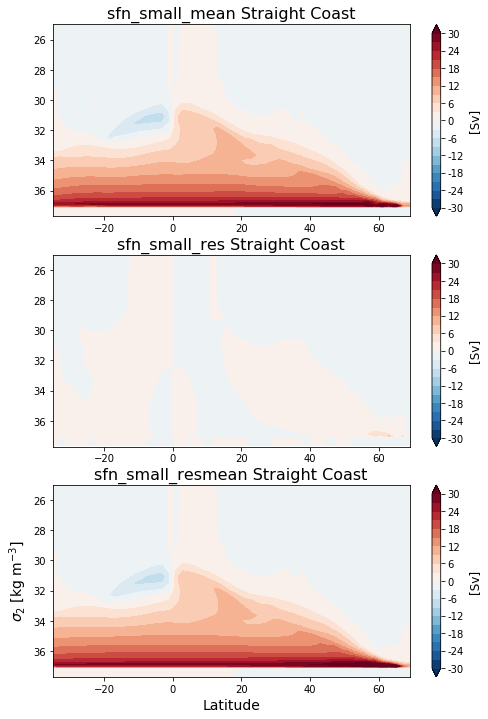

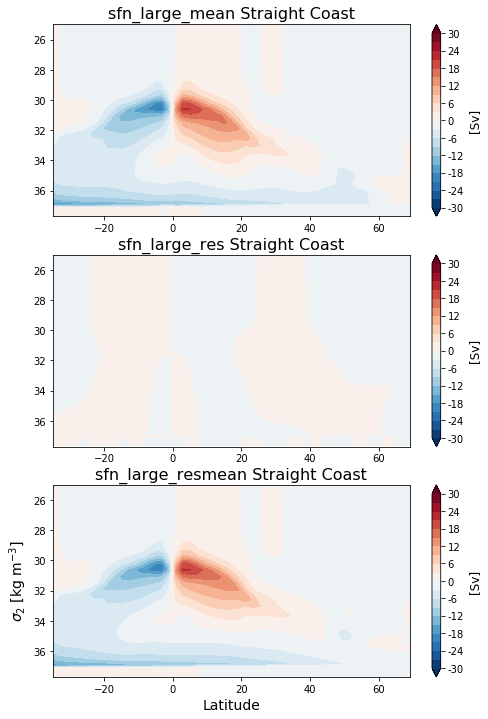

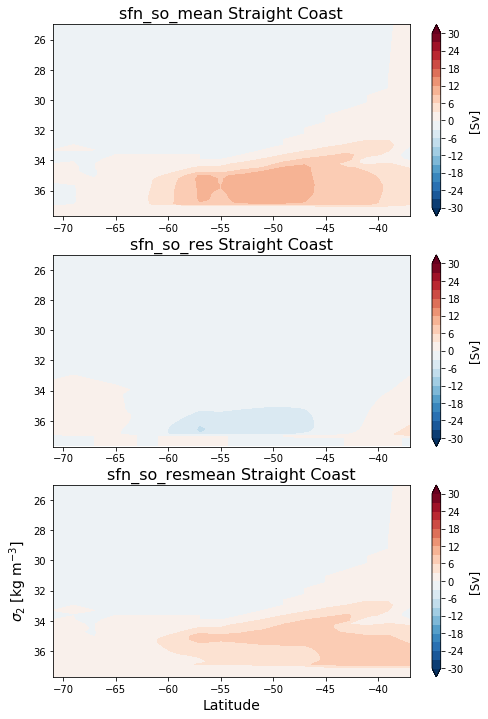

In [42]:
# Plot global mean, residual, and residual mean overturning streamfunction
plot_global_sfn(sfn_mean, sfn_res, sfn_resmean, 30, dy_rho2)

#===========================================
# Comment out the lines below if running AQUA or RIDGE simulations (or simulations with only 1 basin)
# The following lines plot streamfunctions for separate basins.
plot_basin_sfn(sfn_small_mean, sfn_small_res, sfn_small_resmean, 30, dy_rho2, y, y_north)
plot_basin_sfn(sfn_large_mean, sfn_large_res, sfn_large_resmean, 30, dy_rho2, y, y_north)
plot_basin_sfn(sfn_so_mean, sfn_so_res, sfn_so_resmean, 30, dy_rho2, y_south, y)


In [51]:
# Calculate global mean, residual, and residual mean overturning streamfunction
sfn_mean, sfn_res, sfn_resmean = calculate_global_sfn(dy_z.vmo, dy_z.vhGM)

#===========================================
# Comment out the lines below if running AQUA or RIDGE simulations (or simulations with only 1 basin)
# The following lines compute streamfunctions for separate basins.
sfn_small_mean, sfn_small_res, sfn_small_resmean = calculate_basin_sfn(dy_z.vmo, dy_z.vhGM, x_west, x_east, y, y_north)
sfn_large_mean, sfn_large_res, sfn_large_resmean = calculate_basin_sfn(dy_z.vmo, dy_z.vhGM, 0, x_west, y, y_north)
sfn_so_mean, sfn_so_res, sfn_so_resmean = calculate_basin_sfn(dy_z.vmo, dy_z.vhGM, 0, 360, y_south, y)


In [64]:
# Calculate sigma2
dy_z['sigma2'] = calc_sigma2(dy_z, dy.so.isel(time=slice(-31,-1)).mean(dim='time'), 
                             dy.thetao.isel(time=slice(-31,-1)).mean(dim='time'))

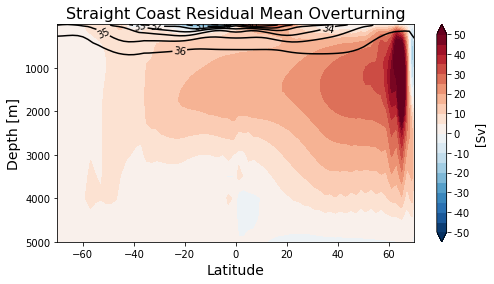

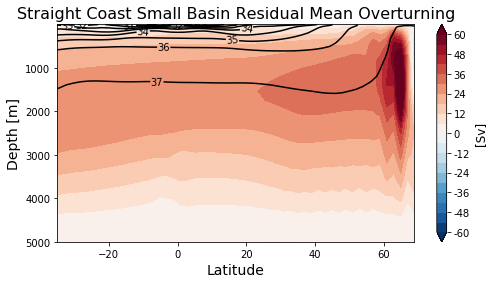

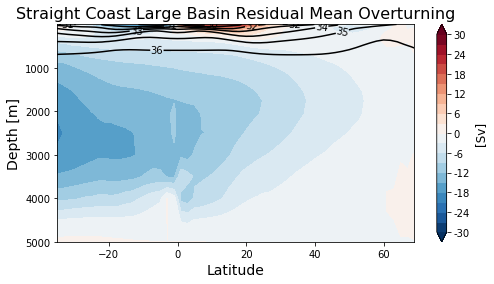

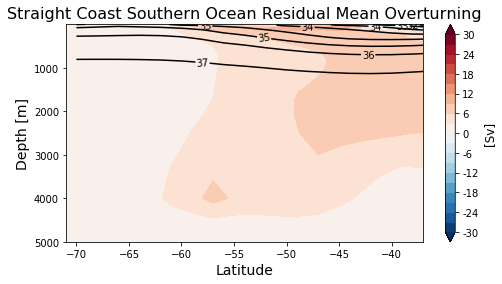

In [99]:
# Plot global mean, residual, and residual mean overturning streamfunction
plot_global_sfn_density(sfn_resmean, 50, dy_z)

#===========================================
# Comment out the lines below if running AQUA or RIDGE simulations (or simulations with only 1 basin)
# The following lines plot streamfunctions for separate basins.
plot_basin_sfn_density(sfn_small_resmean, 60, dy_z, 'Small Basin', x_west, x_east, y, y_north)
plot_basin_sfn_density(sfn_large_resmean, 30, dy_z, 'Large Basin', 0, x_west, y, y_north)
plot_basin_sfn_density(sfn_so_resmean, 30, dy_z, 'Southern Ocean', 0, 360, y_south, y)


In [76]:
sfn_small_resmean

array([[-1.1565992e-01, -3.8452131e-01, -5.8075196e-01, ...,
         7.2715050e-01,  3.1534281e-01, -5.2294546e-01],
       [-1.9788244e-01, -5.3418386e-01, -6.6144449e-01, ...,
         2.2783775e+00,  9.3717939e-01, -1.4256063e+00],
       [ 6.3417546e-02, -2.4115987e-01, -1.9676125e-01, ...,
         3.8305652e+00,  1.5604891e+00, -2.2321320e+00],
       ...,
       [ 1.0871514e+01,  1.0412565e+01,  1.0353547e+01, ...,
         1.3385316e+01,  6.7551832e+00,  1.1025492e+01],
       [ 3.9227259e+00,  3.7790415e+00,  3.7665329e+00, ...,
         4.4504418e+00,  2.2432256e+00,  3.6686671e+00],
       [ 4.4833201e-01,  4.6227974e-01,  4.7302601e-01, ...,
        -1.6995000e-02, -1.2753250e-02, -9.7455001e-03]], dtype=float32)

In [100]:
pwd

'/data/sragen/aquaplanet/MASTERS/CODE'